In [1]:
import torch
import numpy as np
from torch import nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.models import efficientnet_b0
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim import Adam

torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


In [ ]:
os.chdir("/home/tasfreak/Desktop/ML/CIFAR Project")


In [3]:
from Training import ModelTrainer

In [4]:
path = '/home/tasfreak/Desktop/ML/CIFAR Project/Dataset/cifar-10/'

data_df = pd.read_csv(path+'trainLabels.csv',delimiter= ',')
data_df

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
...,...,...
49995,49996,bird
49996,49997,frog
49997,49998,truck
49998,49999,automobile


In [5]:
if 'id' in data_df.columns:
    data_df['path']=path+'/train/'+data_df['id'].astype(str)+'.png'
    data_df.drop(columns='id',inplace=True)
data_df['path'][0]

'/home/tasfreak/Desktop/ML/CIFAR Project/Dataset/cifar-10//train/1.png'

In [6]:
sample_df = data_df.sample(frac=1,random_state=42).reset_index(drop=True) # shuffle the dataframe
sample_df

,label,path
0,horse,/home/tasfreak/Desktop/ML/CIFAR Project/Datase...
1,ship,/home/tasfreak/Desktop/ML/CIFAR Project/Datase...
2,airplane,/home/tasfreak/Desktop/ML/CIFAR Project/Datase...
3,frog,/home/tasfreak/Desktop/ML/CIFAR Project/Datase...
4,automobile,/home/tasfreak/Desktop/ML/CIFAR Project/Datase...
...,...,...
49995,horse,/home/tasfreak/Desktop/ML/CIFAR Project/Datase...
49996,bird,/home/tasfreak/Desktop/ML/CIFAR Project/Datase...
49997,ship,/home/tasfreak/Desktop/ML/CIFAR Project/Datase...
49998,ship,/home/tasfreak/Desktop/ML/CIFAR Project/Datase...


In [7]:
data_df.label.value_counts()

label
frog          5000
truck         5000
deer          5000
automobile    5000
bird          5000
horse         5000
ship          5000
cat           5000
dog           5000
airplane      5000
Name: count, dtype: int64

In [8]:
train_df = sample_df.sample(frac = 0.99)
val_df = sample_df.drop(train_df.index).reset_index(drop=True)
val_df.label.value_counts()

label
horse         60
automobile    54
ship          52
deer          52
truck         49
cat           49
dog           48
frog          46
bird          45
airplane      45
Name: count, dtype: int64

In [9]:
mean=[0.4911, 0.4821, 0.4465]
std=[0.2470, 0.2434, 0.2616]

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]
)

train_transform = transforms.Compose(
    [
        transforms.RandomCrop(size=32,padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply(
            [transforms.ColorJitter(0.1, 0.1, 0.1, 0.02)],
            p=0.5
        ),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]
)


le = LabelEncoder()
le.fit(sample_df['label'])


LabelEncoder()

In [10]:
class CifarDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        super().__init__()
        self.img_path = list(dataframe['path'])
        if type(dataframe['label'][0])==np.int64:
            self.labels = dataframe['label']
        else:
            self.labels = torch.tensor(le.transform(dataframe['label'])).to(device)
        self.transform = transform

    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self, index):
        path = self.img_path[index]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img).to(device)
        return img, self.labels[index]
        


In [11]:
train_dataset = CifarDataset(train_df,train_transform)
val_dataset = CifarDataset(val_df, transform)


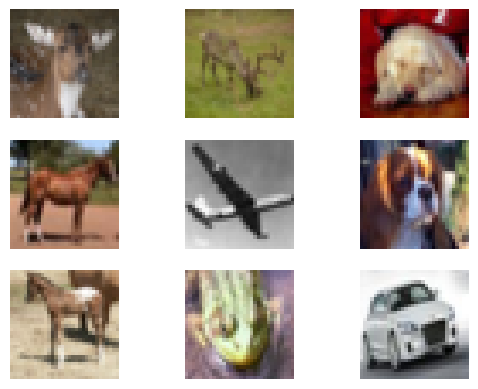

In [12]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
      image = Image.open(data_df.sample(n = 1)['path'].iloc[0]).convert("RGB")
      axarr[row, col].imshow(image)
      axarr[row, col].axis('off')

plt.show()

In [13]:
model = resnet18()
# model = efficientnet_b0(weights='DEFAULT')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
model.fc=nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(model.fc.in_features, 10)
    )
model.to(device)
model.fc
# model.classifier[1].out_features=10
# model.to(device)
# model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=512, out_features=10, bias=True)
)

In [15]:
BATCH_SIZE = 128
EPOCHS = 70
LR = 1e-3

In [16]:
train_data = DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle = True)
val_data = DataLoader(val_dataset,batch_size=BATCH_SIZE, shuffle=True)

In [17]:
loss_project = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr = LR,weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-5)

In [18]:
model_trainer = ModelTrainer(model, train_data=train_data,val_data=val_data,loss_function=loss_project, optimizer=optimizer, scheduler=scheduler)
model_trainer.train(EPOCHS,n_models=50,save='Experiments/AugmentationwithEnsembleDropoutTrick.txt')

Successfully saved the string to Experiments/AugmentationwithEnsembleDropoutTrick.txt
Successfully saved the string to Experiments/AugmentationwithEnsembleDropoutTrick.txt
Successfully saved the string to Experiments/AugmentationwithEnsembleDropoutTrick.txt
Successfully saved the string to Experiments/AugmentationwithEnsembleDropoutTrick.txt
Successfully saved the string to Experiments/AugmentationwithEnsembleDropoutTrick.txt
Successfully saved the string to Experiments/AugmentationwithEnsembleDropoutTrick.txt
Successfully saved the string to Experiments/AugmentationwithEnsembleDropoutTrick.txt
Successfully saved the string to Experiments/AugmentationwithEnsembleDropoutTrick.txt
Successfully saved the string to Experiments/AugmentationwithEnsembleDropoutTrick.txt
Successfully saved the string to Experiments/AugmentationwithEnsembleDropoutTrick.txt
Successfully saved the string to Experiments/AugmentationwithEnsembleDropoutTrick.txt
Successfully saved the string to Experiments/Augmentat

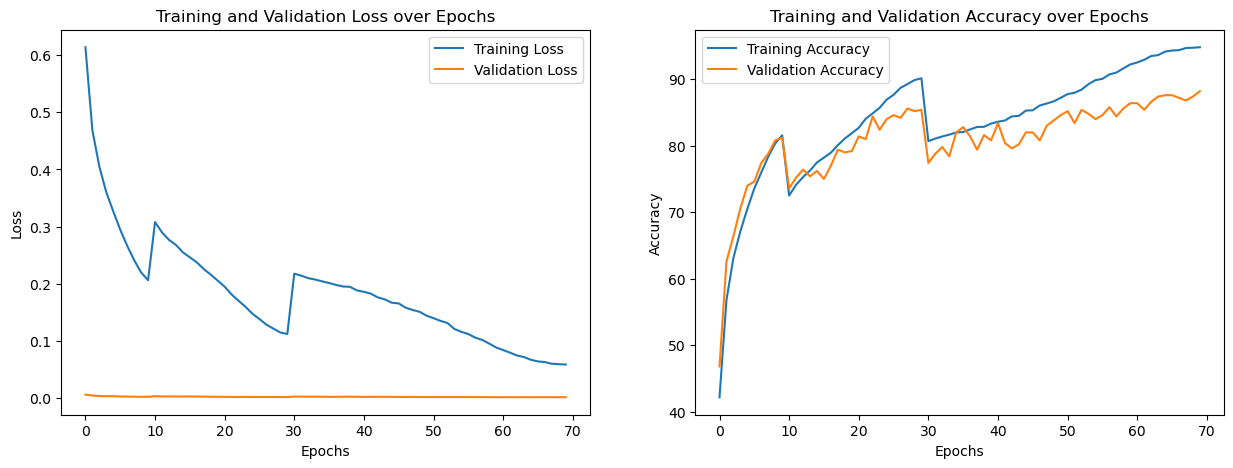

In [19]:
model_trainer.plot_metrics('Experiments/AugmentationwithEnsembleDropoutTrick.png')

In [20]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
# Create a test dataset, run the trained model on it, and write predictions to CSV.
test_dir = '/home/tasfreak/Desktop/ML/CIFAR Project/Dataset/cifar-10/test'
path_len = len(test_dir)+1
test_files = sorted([test_dir+'/'+f for f in os.listdir(test_dir)], key = lambda x: int(x[path_len:-4]))
test_df = pd.DataFrame(test_files, columns=['path'])
test_df['label'] = [int(x[path_len:-4]) for x in test_files]
type(test_df['label'][0])

test_dataset = CifarDataset(test_df, transform)  # use the previously defined `transform`
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

pred_ids = []
pred_labels = []
k=0
model.train()  # keep dropout on  for ensemble
with torch.no_grad():
    for imgs, id in test_loader:
        ensemble_outputs = torch.zeros((imgs.size(0), 100, 10))
        print(k)
        k+=1
        for i in range(100):
            outputs = model(imgs)
            ensemble_outputs[:, i, :] = outputs
        avg_outputs = ensemble_outputs.mean(dim=1).to(device)
        preds = avg_outputs.argmax(dim=1).cpu().numpy()
        labels = le.inverse_transform(preds)
        pred_ids.extend(id.tolist())
        pred_labels.extend(labels.tolist())

submission_df = pd.DataFrame({"id": pred_ids, "label": pred_labels})
out_csv = "test_predictions.csv"
submission_df.to_csv(out_csv, index=False)
print(f"Saved predictions to {out_csv}")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27